In [1]:
import os
os.chdir('../')
os.getcwd()

'c:\\Users\\user\\Desktop\\DTI\\DeepPurpose-1'

In [2]:
from DeepPurpose import utils, dataset
from DeepPurpose import DTI as models
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

In [12]:
#### process_BindingDB ####

# Parameter
path = '../Database/BindingDB/BindingDB_edit_ver2_240125.tsv'
df = None
y = 'IC50'
binary = False
convert_to_log = True
threshold = 30
return_ids = False
ids_condition = 'OR'
harmonize_affinities = None

# loading df (bindingDB)
df = pd.read_csv(path, sep = '\t')

print('Beginning Processing...')
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = []
yy = y
if isinstance(y, str):
	yy = [y]
for y in yy:
	if y == 'Kd':
		idx_str.append('Kd (nM)')
	elif y == 'IC50':
		idx_str.append('IC50 (nM)')
	elif y == 'Ki':
		idx_str.append('Ki (nM)')
	elif y == 'EC50':
		idx_str.append('EC50 (nM)')
	else:
		print('select Kd, Ki, IC50 or EC50')

if len(idx_str)==1:
	df_want = df[df[idx_str[0]].notnull()]
else: # select multiple affinity measurements.                 
	# keep rows for which at least one of the columns in the idx_str list is not null
	df_want = df.dropna(thresh=1, subset=idx_str) 
	
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
				'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
				'modified_both'] + idx_str] # BindingDB Target Chain Sequence

for y in idx_str:
	df_want[y] = df_want[y].str.replace('>', '')
	df_want[y] = df_want[y].str.replace('<', '')
	df_want[y] = df_want[y].astype(float)

# Harmonize into single label using the mean of existing labels:
df_want['Label'] = df_want[idx_str].mean(axis=1, skipna=True)

df_want.rename(columns={'BindingDB Reactant_set_id':'ID',
						'Ligand SMILES':'SMILES',
						'Ligand InChI':'InChI',
						'PubChem CID':'PubChem_ID',
						'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
						'modified_both': 'Target Sequence'}, # BindingDB Target Chain Sequence
						inplace=True)

# have at least uniprot or pubchem ID
if ids_condition == 'OR':
	df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
elif ids_condition == 'AND':
	df_want = df_want[df_want.PubChem_ID.notnull() & df_want.UniProt_ID.notnull()]
else:
	ValueError("ids_condition must be set to 'OR' or 'AND'")

df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[df_want.Label <= 10000000.0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')

if harmonize_affinities is not None:
	df_want = df_want[['PubChem_ID', 'SMILES', 'UniProt_ID', 'Target Sequence', 'Label']]
	if harmonize_affinities.lower() == 'max_affinity':
		df_want = df_want.groupby(['PubChem_ID', 'SMILES', 'UniProt_ID', 'Target Sequence']).Label.agg(min).reset_index()
	if harmonize_affinities.lower() == 'mean':
		df_want = df_want.groupby(['PubChem_ID', 'SMILES', 'UniProt_ID', 'Target Sequence']).Label.agg(np.mean).reset_index()

if binary:
	print('Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter')
	if isinstance(threshold, Sequence):
		# filter samples with affinity values between the thresholds
		df_want = df_want[(df_want.Label < threshold[0]) | (df_want.Label > threshold[1])]
	else: # single threshold
		threshold = [threshold]
	y = [1 if i else 0 for i in df_want.Label.values < threshold[0]]
else:
	if convert_to_log:
		print('Default set to logspace (nM -> p) for easier regression')
		y = utils.convert_y_unit(df_want.Label.values, 'nM', 'p')
	else:
		y = df_want.Label.values
	
if return_ids:
	X_drug, X_target, y, ID_drug, ID_target = df_want.SMILES.values, df_want['Target Sequence'].values, np.array(y), df_want['PubChem_ID'].values, df_want['UniProt_ID'].values
X_drug, X_target, y = df_want.SMILES.values, df_want['Target Sequence'].values, np.array(y)


Beginning Processing...
There are 1592671 drug target pairs.
Default set to logspace (nM -> p) for easier regression


In [4]:
#### select endcoder ####
drug_encoding, target_encoding = 'CNN', 'CNN'

In [5]:
#### data_process ####

# parameter
split_method = 'random'
frac = [0.7, 0.1, 0.2]
random_seed = 1
sample_frac = 1
mode = 'DTI'
X_drug_ = None
X_target_ = None

# data_process : dataframe

if random_seed == 'TDC':
	random_seed = 1234
 
#property_prediction_flag = X_target is None
property_prediction_flag, function_prediction_flag, DDI_flag, PPI_flag, DTI_flag = False, False, False, False, False

if (X_drug is not None) and (X_target is not None):
	DTI_flag = True
	if (X_drug is None) or (X_target is None):
		raise AttributeError("Target pair sequence should be in X_target, X_drug")
else:
	raise AttributeError("Please use the correct mode. Currently, we support DTI, DDI, PPI, Drug Property Prediction and Protein Function Prediction...")

if split_method == 'repurposing_VS':
	y = [-1]*len(X_drug) # create temp y for compatitibility

if DTI_flag:
	print('Drug Target Interaction Prediction Mode...')
	if isinstance(X_target, str):
		X_target = [X_target]
	if len(X_target) == 1:
		# one target high throughput screening setting
		X_target = np.tile(X_target, (length_func(X_drug), ))

	df_data = pd.DataFrame(zip(X_drug, X_target, y))
	df_data.rename(columns={0:'SMILES',
							1: 'Target Sequence',
							2: 'Label'}, 
							inplace=True)
	print('in total: ' + str(len(df_data)) + ' drug-target pairs')
 
# data_process : endcoding & splitting

if sample_frac != 1:
	df_data = df_data.sample(frac = sample_frac) #.reset_index(drop = True)
	print('after subsample: ' + str(len(df_data)) + ' data points...') 

if DTI_flag:
	df_data = utils.encode_drug(df_data, drug_encoding)
	df_data = utils.encode_protein(df_data, target_encoding)

Drug Target Interaction Prediction Mode...
in total: 1592671 drug-target pairs
encoding drug...
unique drugs: 770912
encoding protein...
unique target sequence: 5055


In [6]:
# after pre-processing set 불러오기
after_train = pd.read_csv('C:\\Users\\user\\Desktop\\DTI\\Database\\BindingDB\\BindingDB_index_train.tsv', sep='\t', index_col=0)
after_val = pd.read_csv('C:\\Users\\user\\Desktop\\DTI\\Database\\BindingDB\\BindingDB_index_val.tsv', sep='\t', index_col=0)
after_test = pd.read_csv('C:\\Users\\user\\Desktop\\DTI\\Database\\BindingDB\\BindingDB_index_test.tsv', sep='\t', index_col=0)


In [7]:
after_val['index_val'].values

array([ 520137,    5876,  773576, ...,  253865, 1014785,  758771],
      dtype=int64)

In [8]:
# 같은 index를 가지게 split / index 초기화
train = df_data.loc[after_train['index_train'].values, :]
val = df_data.loc[after_val['index_val'].values, :]
test = df_data.loc[after_test['index_test'].values, :]
train, val, test = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [9]:
# Model configuration genreration
config = utils.generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 50, 
                         test_every_X_epoch = 10, 
                         LR = 0.001, 
                         batch_size = 256,
                         hidden_dim_drug = 128,
                         cnn_drug_filters = [32,64,96],
                         cnn_drug_kernels = [4,6,8],
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )

In [10]:
# Model initialization
model = models.model_initialize(**config)
model

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 41.8658. Total time 0.00083 hours
Training at Epoch 1 iteration 100 with loss 2.08005. Total time 0.01944 hours
Training at Epoch 1 iteration 200 with loss 2.35410. Total time 0.03777 hours
Training at Epoch 1 iteration 300 with loss 1.92962. Total time 0.05611 hours
Training at Epoch 1 iteration 400 with loss 1.64487. Total time 0.07472 hours
Training at Epoch 1 iteration 500 with loss 1.62951. Total time 0.09305 hours
Training at Epoch 1 iteration 600 with loss 1.62219. Total time 0.11138 hours
Training at Epoch 1 iteration 700 with loss 1.58678. Total time 0.12972 hours
Training at Epoch 1 iteration 800 with loss 1.59107. Total time 0.14805 hours
Training at Epoch 1 iteration 900 with loss 1.39033. Total time 0.16638 hours
Training at Epoch 1 iteration 1000 with loss 1.43088. Total time 0.18472 hours
Training at Epoch 1 iteration 1100 with loss 1.68081. Total time 0.20277 hour

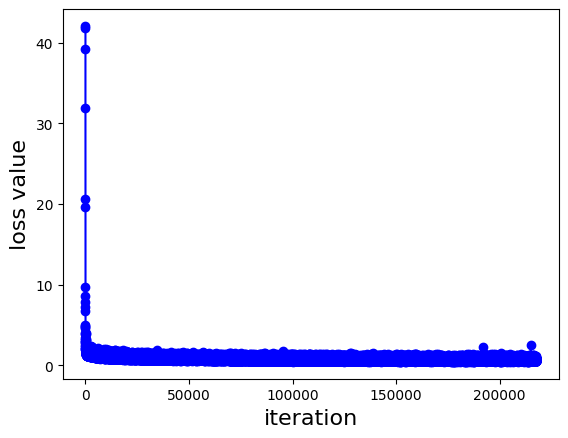

In [11]:
# Model training
model.train(train, val, test)

# Model saving
model.save_model('./pretrained_model/CNN_CNN_BindingDB_IC50_both/')